# Univariate and Bivariate Von Mises distributions implemented in Numpyro

In [1]:
import jax
import jax.numpy as np
import jax.random as random
import numpy as onp
import math

from jax.scipy.linalg  import solve_triangular
from jax.scipy.special import gammaln, log_ndtr, multigammaln, ndtr, ndtri, logsumexp
from jax import grad, jit, vmap, lax, ops
from numpyro.distributions import constraints, Normal, Uniform
from numpyro.distributions.distribution import Distribution, TransformedDistribution
from numpyro.util import copy_docs_from
from functools import partial
from numpyro.distributions.util import lazy_property, promote_shapes, validate_sample

"""The implementation of the univariate Von Mises distribution follows the implementation of the same
distribution in Pytorch torch.distributions package. The original code for the Pytorch implementation can be 
found athttps://pytorch.org/docs/stable/_modules/torch/distributions/von_mises.html#VonMises"""

_I0_COEF_SMALL = np.array([1.0, 3.5156229, 3.0899424, 1.2067492, 0.2659732, 0.360768e-1, 0.45813e-2])
_I0_COEF_LARGE = np.array([0.39894228, 0.1328592e-1, 0.225319e-2, -0.157565e-2, 0.916281e-2,
                  -0.2057706e-1, 0.2635537e-1, -0.1647633e-1, 0.392377e-2])
_I1_COEF_SMALL = np.array([0.5, 0.87890594, 0.51498869, 0.15084934, 0.2658733e-1, 0.301532e-2, 0.32411e-3])
_I1_COEF_LARGE = np.array([0.39894228, -0.3988024e-1, -0.362018e-2, 0.163801e-2, -0.1031555e-1,
                  0.2282967e-1, -0.2895312e-1, 0.1787654e-1, -0.420059e-2])

@jit
def _log_modified_bessel_fn(x, order):
    """
    Returns ``log(I_order(x))`` for ``x > 0``,
    where `order` is either 0 or 1.
    
    Based on https://pytorch.org/docs/stable/_modules/torch/distributions/von_mises.html#VonMises
    """
    # compute small solution
    y = (x / 3.75)
    y = y * y
    
    COEF_SMALL = np.where(np.ones((7,))*order, _I1_COEF_SMALL, _I0_COEF_SMALL)
    COEF_LARGE = np.where(np.ones((9,))*order, _I1_COEF_LARGE, _I0_COEF_LARGE)
    
    small = _eval_poly_small(y, COEF_SMALL)
    small = np.where(np.ones(x.shape)*order, abs(x) * small, small)
    small = np.log(small)

    # compute large solution
    y = 3.75 / x
    large = x - 0.5 * np.log(x) + np.log(_eval_poly_large(y, COEF_LARGE))

    result = np.where(x < 3.75, small, large)
    return result

@jit
def _eval_poly_small(y, coef):
    return coef[-7] + y*(coef[-6] + y*(coef[-5] + y*(coef[-4] + y*(coef[-3] + y*(coef[-2] + y*coef[-1])))))

@jit
def _eval_poly_large(y, coef):
    return coef[-9] + y*(coef[-8] + y*(coef[-7] + y*( coef[-6] + 
                        y*(coef[-5] + y*(coef[-4] + y*(coef[-3] + y*(coef[-2] + y*coef[-1])))))))

@jit
def condition(args):
    return ~np.all(args[2])

@jit
def loop(args):
    x, proposal_r, done, key, concentration = args
    key, subkey = jax.random.split(key)
    u = jax.random.uniform(subkey, shape = (3,) + x.shape)
    u1, u2, u3 = u.squeeze()
    z = np.cos(math.pi * u1)
    f = (1 + proposal_r * z) / (proposal_r + z)
    c = concentration * (proposal_r - f)
    accept = ((c * (2 - c) - u2) > 0) | (np.log(c / u2) + 1 - c >= 0)
    x = np.where(accept, np.sign(u3 - 0.5) * np.arccos(f),  x)          
    done = done | accept
    return x, proposal_r, done, key, concentration

@jit
def _rejection_sample(loc, concentration, proposal_r, key, x):
    """
    Acceptance-rejection sampling method – translated from the Pytorch Von Mises implementation. 
    
    The sampling algorithm for the von Mises distribution is based on the following paper:
    Best, D. J., and Nicholas I. Fisher.
    "Efficient simulation of the von Mises distribution." Applied Statistics (1979): 152-157.
    """
    
    done = np.zeros(x.shape, dtype=bool)
    x = lax.while_loop(condition, loop, (x, proposal_r, done, key, concentration))[0]
    return (x + math.pi + loc) % (2 * math.pi) - math.pi
    
@copy_docs_from(Distribution)
class VonMises(Distribution):
    """
    A circular von Mises distribution.

    This implementation uses polar coordinates. The ``loc`` and ``value`` args
    can be any real number (to facilitate unconstrained optimization), but are
    interpreted as angles modulo 2 pi.

    :param int: an angle in radians.
    :param int: concentration parameter
    
    Based on https://pytorch.org/docs/stable/_modules/torch/distributions/von_mises.html#VonMises
    """
    arg_constraints = {'loc': constraints.real, 'concentration': constraints.positive}
    support = constraints.real
    has_rsample = False
    
    def __repr__(self):
        return str(type(self).__name__) + "(loc: " + str(self.loc) + ", concentration: " + str(self.concentration) + ")"

    def __init__(self, loc, concentration, validate_args=None):
        self.loc, self.concentration = promote_shapes(loc, concentration)
        batch_shape = lax.broadcast_shapes(np.shape(loc), np.shape(concentration))
        event_shape = ()

        # Parameters for sampling
        tau = 1 + np.sqrt(1 + 4 * self.concentration ** 2)
        rho = (tau - np.sqrt(2 * tau)) / (2 * self.concentration)
        self._proposal_r = (1 + rho ** 2) / (2 * rho)
        super(VonMises, self).__init__(batch_shape, event_shape, validate_args)

    def log_prob(self, value):
        log_prob = self.concentration * np.cos(value - self.loc)
        log_prob = log_prob - math.log(2 * math.pi) - _log_modified_bessel_fn(self.concentration, 0)
        return log_prob
    
    def sample(self, key, sample_shape = ()):
        """
        The sampling algorithm for the von Mises distribution is based on the following paper:
        Best, D. J., and Nicholas I. Fisher.
        "Efficient simulation of the von Mises distribution." Applied Statistics (1979): 152-157.
        
        Based on https://pytorch.org/docs/stable/_modules/torch/distributions/von_mises.html#VonMises
        """
        if isinstance(sample_shape, int):
            shape = tuple([sample_shape]) + self.batch_shape + self.event_shape
        else:
            shape = sample_shape + self.batch_shape + self.event_shape
        x = np.empty(shape)            
        return _rejection_sample(self.loc, self.concentration, self._proposal_r, key, x)

    def expand(self, batch_shape):
        """
        Function to initialize batch_shape number of parallel distributions
        """
        validate_args = self.__dict__.get('_validate_args')
        loc = np.ones(batch_shape)*self.loc
        concentration = np.ones(batch_shape)*self.concentration
        return VonMises(loc, concentration, validate_args=validate_args)

    @property
    def mean(self):
        """
        The provided mean is the circular one.
        """
        return self.loc

    @lazy_property
    def variance(self):
        """
        The provided variance is the circular one.
        """
        return 1 - np.exp(_log_modified_bessel_fn(self.concentration, 1) -
                    _log_modified_bessel_fn(self.concentration, 0))

## Bivariate Von Mises – sampling & logCinv 

In [2]:
@partial(jit, static_argnums = (0,))
def logCinv(k1, k2, lam):
    """Harshinder Singh, Vladimir Hnizdo, and Eugene Demchuk
    Probabilistic model for twodependent circular variables.
    Biometrika, 89(3):719–723, 2002.

    Closed form expression of the normalizing constant
    Vectorized and in log-space
    
    k1, k2 & lam are the parameters from the bivariate von Mises
    
    Since the closed expression is an infinite sum, 'terms' is the number
    of terms, over which the expression is summed over. Estimation by convergence. 
    
    The code is translated to Numpyro from Christian Breinholt's Pytorch implementation. 
    """
    lam = np.abs(lam) + 1e-8 
    if isinstance(k1, int) or isinstance(k1, float):
        m = lax.iota(np.float32, 51)
    else:
        m = (lax.iota(np.float32, 51)*np.ones([len(k1), 1])).T
                                         
    log_binom = gammaln(2*m+1) - (gammaln(m+1) + gammaln((m)+1)) 
    logC = log_binom + m*((2*np.log(lam)) - np.log(4*k1*k2)) + _log_modified_bessel_fn(k1, 0) + _log_modified_bessel_fn(k2, 0)
    return (np.log(4) + 2* np.log(math.pi) + logsumexp(logC, -1))

@partial(jit, static_argnums = (0,1,))
def _acg_bound(sample, k1, k2, alpha, key):
    lam = np.concatenate((np.zeros([len(k1), 1]), 0.5*(k1 - alpha**2/k2).reshape(len(k1), 1)), axis = 1)
    lambda_min = np.min(lam, axis = 1).reshape([len(k1), 1])
    lam = lam - lambda_min
    b_values = np.concatenate((np.array(np.sqrt(lam[:,1]**2 + 1) - lam[:,1]
                                        + 1).reshape([len(k1), 1]), np.ones([len(k1),1])*2), axis = 1)
    b0 = np.min(b_values, axis = 1).reshape([len(k1), 1])

    phi = 1 + 2*lam/b0
    den = _log_modified_bessel_fn(k2, 0)
    accept = np.zeros((sample.shape[0], k1.shape[0], 1), dtype = "bool_")
    args = (key, phi, k1, k2, lam, lambda_min, sample, accept, den, b0, alpha)
    res = lax.while_loop(loop_condition, loop_acg, args)[6]
    
    return np.arctan2(res[...,1], res[...,0])

@jit
def loop_acg(args):
    key, phi, k1, k2, lam, lambda_min, sample, accept, den, b0, alpha = args
    key, subkey = jax.random.split(key)
    x = np.where(accept, 0,  jax.random.normal(subkey, sample.shape) * np.sqrt(1/phi))    
    r = np.sqrt(np.sum(x**2, axis = -1))        
    r = np.expand_dims(r, axis=-1)
    x = x/r
    u = (x**2 * lam).sum(-1)
    v = jax.random.uniform(subkey, (sample.shape[0], k1.shape[0]))

    logf = k1*(x[...,0] - 1) + lambda_min.T + _log_modified_bessel_fn(np.sqrt(k2**2 + alpha**2 * x[...,1]**2), 0) - den           
    loggi = 0.5 * (2 - b0.T) + np.log(1 + 2*u/b0.T) + np.log(b0.T/2)
    logfg = np.add(logf, loggi)
    logfg = logfg.reshape([sample.shape[0], k1.shape[0]])
    
    accept = v < np.exp(logfg)
    accept = accept[..., None]
    sample = np.where(accept, x,  sample)

    return (key, phi, k1, k2, lam, lambda_min, sample, accept, den, b0, alpha)

@jit
def loop_condition(args):
    return np.count_nonzero(np.isnan(args[6])) > 0

## Bivariate Von Mises Distribution class

In [3]:
from numpyro.distributions.distribution import Distribution
import time
@copy_docs_from(Distribution)
class BivariateVonMises(Distribution):
    """
    Bivariate von Mises (Sine Model) distribution on the torus
    
    Modality:
        If lam^2 / (k1*k2) > 1, the distribution is bimodal, otherwise unimodal.
            - This distribution is only defined for some 'slightly' bimodal cases (alpha < -7)
    
    :param mu, nu: an angle in radians.
        - mu & nu can be any real number but are interpreted as 2*pi
    :param k1, k2: concentration parameters
        - This distribution is only defined for k1, k2 > 0
    :param lam: correlation parameter
        - Can be any real number, but is not defined for very bimodal cases (see 'Modality')        
    :param w: reparameterization parameter
        - Has to be between -1 and 1
    """
    arg_constraints = {'mu':  constraints.real, 
                       'nu':  constraints.real,
                       'k1':  constraints.positive, 
                       'k2':  constraints.positive, 
                       'lam': constraints.real}
    support = constraints.real
    has_rsample = False
    
    def __repr__(self):
        param = self.lam
        printing = ", lam: "
        if self.lam is None:
            param = self.w
            printing = ", w: "
        return str(type(self).__name__) + "(mu: " + str(self.mu) + ", nu: " + str(self.nu) + ", k1: " + str(self.k1) + ", k2: " + str(self.k2) + printing + str(param) + ")"

    def __init__(self, mu, nu, k1, k2, lam = None, w = None, validate_args = None):
        if lam is None == w is None:
            raise ValueError("Either `lam` or `w` must be specified, but not both.")
        elif w is None:
            self.mu, self.nu, self.k1, self.k2, self.lam = promote_shapes(mu, nu, k1, k2, lam)
            alpha = 0.5*(self.k1 - (self.lam)**2/self.k2) 
            if not np.all(alpha > -7): 
                raise ValueError("Distribution is too bimodal or has too high concentration while being bimodal.")
        
        elif lam is None:
            self.mu, self.nu, self.k1, self.k2, self.w = promote_shapes(mu, nu, k1, k2, w)
            self.lam = np.sqrt(self.k1*self.k2) * self.w
            alpha = 0.5*(self.k1 - (self.lam)**2/self.k2) 
            if not np.all(alpha > -7): 
                raise ValueError("Distribution is too bimodal or has too high concentration while being bimodal.")
                
        batch_shape = lax.broadcast_shapes(np.shape(self.mu), 
                                           np.shape(self.nu),
                                           np.shape(self.k1),
                                           np.shape(self.k2),
                                           np.shape(self.lam))
        event_shape = (2,)
        
        self.logC = logCinv(self.k1, self.k2, self.lam)
        super(BivariateVonMises, self).__init__(batch_shape, event_shape, validate_args)
    
    
    def sample(self, key, sample_shape = (1)):
        """ Harshinder Singh, Vladimir Hnizdo, and Eugene Demchuk
            Probabilistic model for twodependent circular variables.
            Biometrika, 89(3):719–723, 2002.
            
        marg: marginal distribution (using _acg_bound())
        cond: conditional distribution using a modified univariate von Mises (as described in Singh et al. (2002))
        
        The sampling method follows Christian Breinholt's Pytorch implementation. 
        """
        if isinstance(sample_shape, int):
            shape = tuple([sample_shape]) + self.batch_shape + self.event_shape
        else:
            shape = sample_shape + self.batch_shape + self.event_shape
            
        x = np.empty(shape)*np.nan
      
        if isinstance(self.k1, int) or isinstance(self.k1, float):
            marg = _acg_bound(x[:,None], np.array([self.k1])[:,None], np.array([self.k2])[:,None], np.array([self.lam])[:,None], key) #Sampling from marginal distribution
            marg = (marg + self.mu + math.pi) % (2 * math.pi) - math.pi
            marg = np.squeeze(marg)
        elif len(self.k1) == 1:
            marg = _acg_bound(x, self.k1[:,None], self.k2[:,None], self.lam[:,None], key) #Sampling from marginal distribution
            marg = (marg + self.mu + math.pi) % (2 * math.pi) - math.pi
            marg = np.squeeze(marg)
        else:
            marg = _acg_bound(x, self.k1, self.k2, self.lam, key)       #Sampling from marginal distribution
            marg = (marg + self.mu + math.pi) % (2 * math.pi) - math.pi       #Applying mean angle
          
        alpha = np.sqrt(self.k2**2 + self.lam**2 * np.sin(marg - self.mu)**2) #Sampling from conditional distribution
        beta  = np.arctan(self.lam / self.k2 * np.sin(marg - self.mu))
        cond  = VonMises(self.nu + beta, alpha).sample(key)
        return np.array([marg, cond]).T
    
    
    def expand(self, batch_shape):
        validate_args = self.__dict__.get('_validate_args')
        mu = np.ones(batch_shape)*self.mu
        nu = np.ones(batch_shape)*self.nu
        k1 = np.ones(batch_shape)*self.k1
        k2 = np.ones(batch_shape)*self.k2

        if self.lam is not None:
            lam = np.ones(batch_shape)*self.lam
            w = None
        else:
            w = np.ones(batch_shape)*self.w
            lam = None
        
        return BivariateVonMises(mu, nu, k1, k2, lam = lam, w = w, validate_args=validate_args)
    
    @validate_sample
    def log_prob(self, angles):
        """ Actual likelihood function, log joint distribution of phi and psi.
        The code was translated from Christian Breinholt's Pytorch implementation"""
        phi = angles[:,0]
        psi = angles[:,1]
        return (self.k1 * np.cos(phi - self.mu) + self.k2 * np.cos(psi - self.nu) + 
                self.lam * np.sin(phi - self.mu) * np.sin(psi - self.nu)) - self.logC
    

## Ramachandran_plot – function to plot psi and phi angles 

In [4]:
def Ramachandran_plot(data_angles, rang):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    degrees = np.rad2deg(data_angles) 
    phi = degrees[:,0] 
    psi = degrees[:,1] 
    plt.figure(figsize=(7, 6))
    plt.hist2d(phi, psi, bins = 200, norm = LogNorm(), cmap = plt.cm.jet )

    plt.suptitle("Ramachandran plot, {} samples from Bivariate von Mises".format(n))
    plt.title("mu = {}, nu = {}, k1 = {}, k2 = {}, lam = {}".format(mu, nu, k1, k2, lam))
    plt.xlabel('φ')
    plt.ylabel('ψ')    
    c = rang
    plt.xlim(-c, c)
    plt.ylim(-c, c)
    plt.colorbar();

## Sampling from bivariate Von Mises – initializing one distribution 

In [5]:
mu = 0.
nu = 0.
k1 = 60.
k2 = 70.
lam = 15.
bvms_a = BivariateVonMises(mu = mu, nu = nu, k1 = k1, k2 = k2, lam = lam)
rng_key = random.PRNGKey(190)

n = 100000
start = time.time()
angles = bvms_a.sample(rng_key, n)
end = time.time()

print(end-start)
angles

2.170754909515381


DeviceArray([[-0.07296538,  0.20313692],
             [-0.1757698 , -0.19215035],
             [-0.0953083 , -0.03644371],
             ...,
             [-0.1884067 , -0.09743619],
             [ 0.00737262, -0.06369281],
             [-0.0060432 , -0.02652359]], dtype=float32)

In [6]:
mu = np.array([0])
nu = np.array([0])
k1 = np.array([60])
k2 = np.array([70])
lam = np.array([15])
bvms_a = BivariateVonMises(mu = mu, nu = nu, k1 = k1, k2 = k2, lam = lam)
rng_key = random.PRNGKey(190)

n = 100000
start = time.time()
angles = bvms_a.sample(rng_key, n)
end = time.time()

print(end-start)
angles

1.340487003326416


DeviceArray([[-0.07296538,  0.20313692],
             [-0.1757698 , -0.19215035],
             [-0.0953083 , -0.03644371],
             ...,
             [-0.1884067 , -0.09743619],
             [ 0.00737262, -0.06369281],
             [-0.0060432 , -0.02652359]], dtype=float32)

## Sampling from bivariate Von Mises – initializing multiple distributions

In [7]:
mu_np = np.array([0., 0.2, 1.0, 0])
nu_np = np.array([0., 0.2, 1.0, 0])
k1_np = np.array([60., 70., 65., 70])
k2_np = np.array([70., 60., 65., 70])
lam_np = np.array([15., 5., 7.5, 6])

rng_key = random.PRNGKey(190)
bvms_b = BivariateVonMises(mu = mu_np, nu = nu_np, k1 = k1_np, k2 = k2_np, lam = lam_np)

time_start = time.time()
angles_parallel = bvms_b.sample(rng_key, 100000)
ended = time.time()

print(ended - time_start)
angles_parallel

3.5699689388275146


DeviceArray([[[ 1.03859186e-01,  1.94931030e-02],
              [ 9.99689102e-04, -5.64024448e-02],
              [ 2.13141918e-01, -5.78718185e-02],
              ...,
              [-9.81035233e-02, -1.11963749e-01],
              [ 7.59158134e-02,  1.82037354e-02],
              [-2.23716497e-01, -9.15741920e-03]],

             [[ 3.74607325e-01,  3.57963800e-01],
              [ 3.62720013e-01,  2.17436075e-01],
              [ 2.50025272e-01,  1.86876059e-01],
              ...,
              [ 1.58724546e-01,  1.03395700e-01],
              [ 8.16111565e-02,  2.43496180e-01],
              [ 3.02416086e-01,  2.03363419e-01]],

             [[ 1.18045974e+00,  9.72223997e-01],
              [ 8.81632566e-01,  1.05165219e+00],
              [ 1.15940595e+00,  1.07149816e+00],
              ...,
              [ 1.14645410e+00,  1.04244304e+00],
              [ 1.18356347e+00,  8.80036592e-01],
              [ 8.48128080e-01,  9.77471113e-01]],

             [[-6.82718754e-02, -6.55

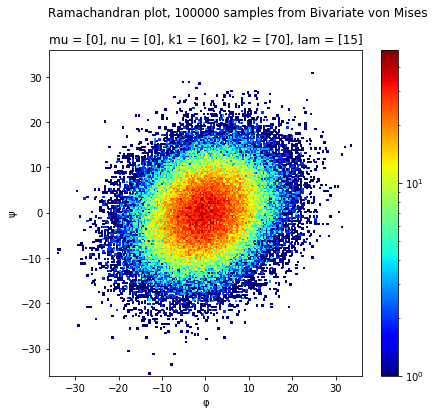

In [10]:
Ramachandran_plot(angles_parallel[0], 36)

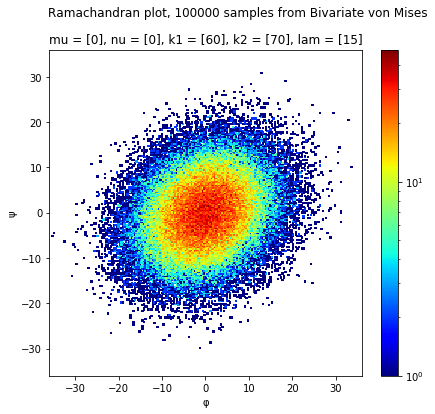

In [11]:
Ramachandran_plot(angles, 36)